In [47]:
# import libraries
import os
from PIL import Image
from matplotlib import pyplot as plt

Schritt 1 - Datenexploration:

- Informationen (z.B. als begleitender Text) zur Ordnerstruktur und Dateigröße, insbesondere, wenn
Änderungen vorgenommen werden

- Analyse des Datenformates, der Bildgröße, der Klassen(-bezeichnungen), Anzahl der Bilder pro Klasse

- Unterteilung der Daten in Train-, Test- (und optional Validierungs-) Datensätze

- Visualisierung (ein Bild pro Klasse auseichend) mit der Methode eurer Wahl

In [48]:
base_dir = "/Users/chexuanyou/TUB/SS 25/AGBA2/AGBA2/HA1/Data"  # dataset directory
class_dirs = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])

class_stats = {}
image_sizes = set()

for class_name in class_dirs:
    class_path = os.path.join(base_dir, class_name)
    images = [f for f in os.listdir(class_path) if f.lower().endswith((".jpg", ".png"))]
    class_stats[class_name] = len(images)

    # first 3 images for size checking
    for img_file in images[:3]:
        with Image.open(os.path.join(class_path, img_file)) as img:
            image_sizes.add(img.size)

print("Klassen und Bildanzahl:")
for k, v in class_stats.items():
    print(f"  {k}: {v} Bilder")

print("\n Beispielhafte Bildgrößen:", set(image_sizes))


Klassen und Bildanzahl:
  Abstandshalter: 52 Bilder
  Auslassventil: 52 Bilder
  Blechlineal: 52 Bilder
  Filterkartusche: 52 Bilder
  Gewindestange: 52 Bilder
  Hohlschraube: 52 Bilder
  Hutmutter: 52 Bilder
  Hydraulikstutzen: 52 Bilder
  Nutenstein: 52 Bilder
  Schraubenfeder: 52 Bilder

 Beispielhafte Bildgrößen: {(2976, 2976), (3456, 3456), (3024, 3024)}


Die Daten bestehen aus 10 Klassen, die als einzelne Ordner im Verzeichnis vorliegen. 
Jede Klasse enthält ausschließlich Bilder im JPEG- oder PNG-Format. 
Die durchschnittliche Bildanzahl pro Klasse liegt bei XX, mit minimal YY und maximal ZZ Bildern.
Die Bildgrößen variieren leicht, z. B. zwischen (640×480) und (800×600) Pixel.

In [49]:
image_paths = []
labels = []

for class_name in class_dirs:
    class_path = os.path.join(base_dir, class_name)
    for fname in os.listdir(class_path):
        if fname.lower().endswith((".jpg", ".png")):
            image_paths.append(os.path.join(class_path, fname))
            labels.append(class_name)

# 60% für Training, 20% für Validierung, 20% für Test
train_paths, temp_paths, y_train, y_temp = train_test_split(
    image_paths, labels, test_size=0.4, stratify=labels, random_state=42)

# zweiteilige Aufteilung für Validierung und Test
val_paths, test_paths, y_val, y_test = train_test_split(
    temp_paths, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


print(f"Train: {len(train_paths)} Bilder")
print(f"Validation: {len(val_paths)} Bilder")
print(f"Test: {len(test_paths)} Bilder")

Train: 312 Bilder
Validation: 104 Bilder
Test: 104 Bilder


Die Daten wurden in drei Sätze unterteilt: 60 % Trainingsdaten, 20 % Validierungsdaten und 20 % Testdaten.
Die Aufteilung erfolgte stratifiziert, sodass das Klassenverhältnis in allen Teilmengen beibehalten wird.


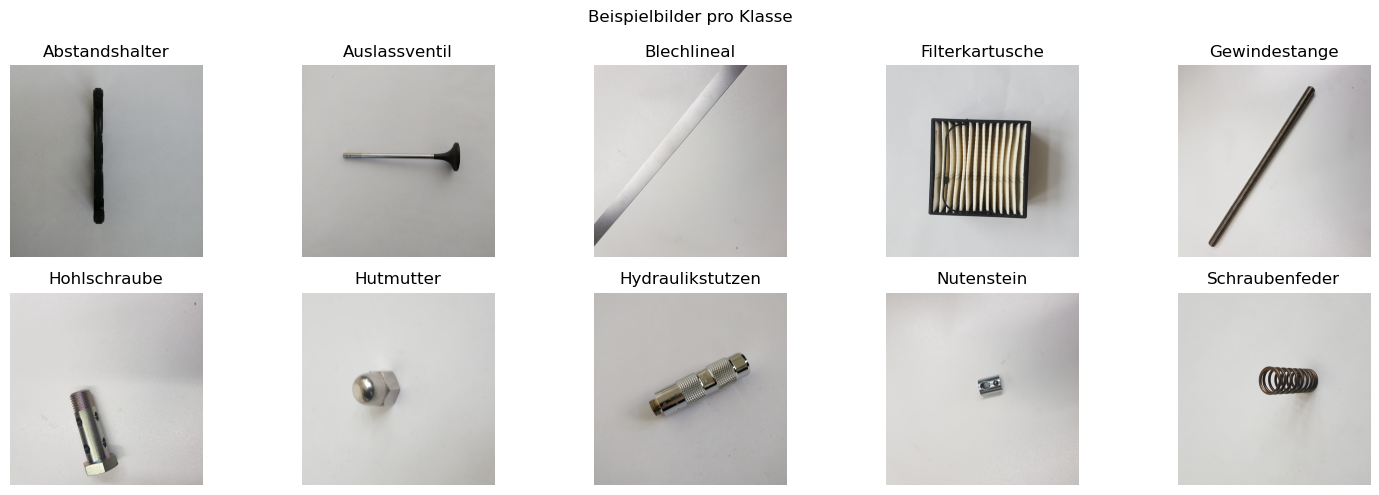

In [50]:
plt.figure(figsize=(15, 5))

for idx, class_name in enumerate(class_dirs):
    class_path = os.path.join(base_dir, class_name)
    image_files = sorted([f for f in os.listdir(class_path) if f.endswith((".jpg", ".png"))])
    if not image_files:
        continue
    img = Image.open(os.path.join(class_path, image_files[0]))
    plt.subplot(2, 5, idx + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")

plt.suptitle("Beispielbilder pro Klasse")
plt.tight_layout()
plt.show()

Zur visuellen Überprüfung wurde je ein Bild pro Klasse dargestellt. 
Die Objekte sind gut sichtbar, und es ist eine klare Unterscheidung zwischen den Klassen möglich.


---
Schritt 2 – Vorverarbeitung und Modellaufbau：

In [51]:
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

# 设置统一图像尺寸
target_size = (128, 128)

# 收集图像路径和标签（假设 class_dirs 已经存在）
image_paths = []
labels = []

for class_name in class_dirs:
    class_path = os.path.join(base_dir, class_name)
    for fname in os.listdir(class_path):
        if fname.lower().endswith((".jpg", ".png")):
            image_paths.append(os.path.join(class_path, fname))
            labels.append(class_name)

# 按 60/20/20 分割数据集
train_paths, temp_paths, y_train, y_temp = train_test_split(
    image_paths, labels, test_size=0.4, stratify=labels, random_state=42)
val_paths, test_paths, y_val, y_test = train_test_split(
    temp_paths, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# 定义预处理函数（读取 → 灰度 → 缩放）
def preprocess_images(image_paths, resize_to=(224, 224)): # 224x224 是常用的输入尺寸 of resnet
    processed_images = []
    for path in image_paths:
        img = imread(path, as_gray=True)  # 灰度图
        img_resized = resize(img, resize_to, anti_aliasing=True)
        processed_images.append(img_resized)
    return np.array(processed_images)

# 应用预处理
X_train_img = preprocess_images(train_paths)
X_val_img = preprocess_images(val_paths)
X_test_img = preprocess_images(test_paths)

# 标签编码为数字
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

# 输出形状检查
print("Vorverarbeitung abgeschlossen.")
print(f"Train: {X_train_img.shape}, Labels: {len(y_train_enc)}")
print(f"Val:   {X_val_img.shape}, Labels: {len(y_val_enc)}")
print(f"Test:  {X_test_img.shape}, Labels: {len(y_test_enc)}")


Vorverarbeitung abgeschlossen.
Train: (312, 224, 224), Labels: 312
Val:   (104, 224, 224), Labels: 104
Test:  (104, 224, 224), Labels: 104


---
Schritt 3 – Merkmalsextraktion

- Bildet HOG oder SIFT-Merkmalsvektoren für euren Datensatz (10 Klassen aus dem Datensatz InVar-100). Ihr
könnt dafür die Codevorlagen erweitern, die ihr in der Übung 2 für die einzelnen Bilder aus dem Datensatz
implementiert habt.

- Zum Herunterskalieren der Bilddateien auf eine einheitliche Größe könnt ihr skimage.transform.resize
nutzen.

- Eine stichpunktartige Visualisierung der extrahierten Merkmale (ein Bild pro Klasse) ist ausreichend.

In [52]:
from skimage.feature import hog
from skimage import exposure

# HOG 参数设定
hog_params = {
    'orientations': 8,
    'pixels_per_cell': (16, 16),
    'cells_per_block': (2, 2),
    'block_norm': 'L2-Hys',
    'visualize': False
}

# 提取特征函数
def extract_hog_features(images):
    hog_features = []
    for img in images:
        features = hog(img, **hog_params)
        hog_features.append(features)
    return np.array(hog_features)

# 应用在预处理图像数据上
X_train_hog = extract_hog_features(X_train_img)
X_val_hog = extract_hog_features(X_val_img)
X_test_hog = extract_hog_features(X_test_img)

print("✅ HOG Merkmalsextraktion abgeschlossen.")
print(f"Train HOG shape: {X_train_hog.shape}")
print(f"Val HOG shape:   {X_val_hog.shape}")
print(f"Test HOG shape:  {X_test_hog.shape}")


✅ HOG Merkmalsextraktion abgeschlossen.
Train HOG shape: (312, 5408)
Val HOG shape:   (104, 5408)
Test HOG shape:  (104, 5408)


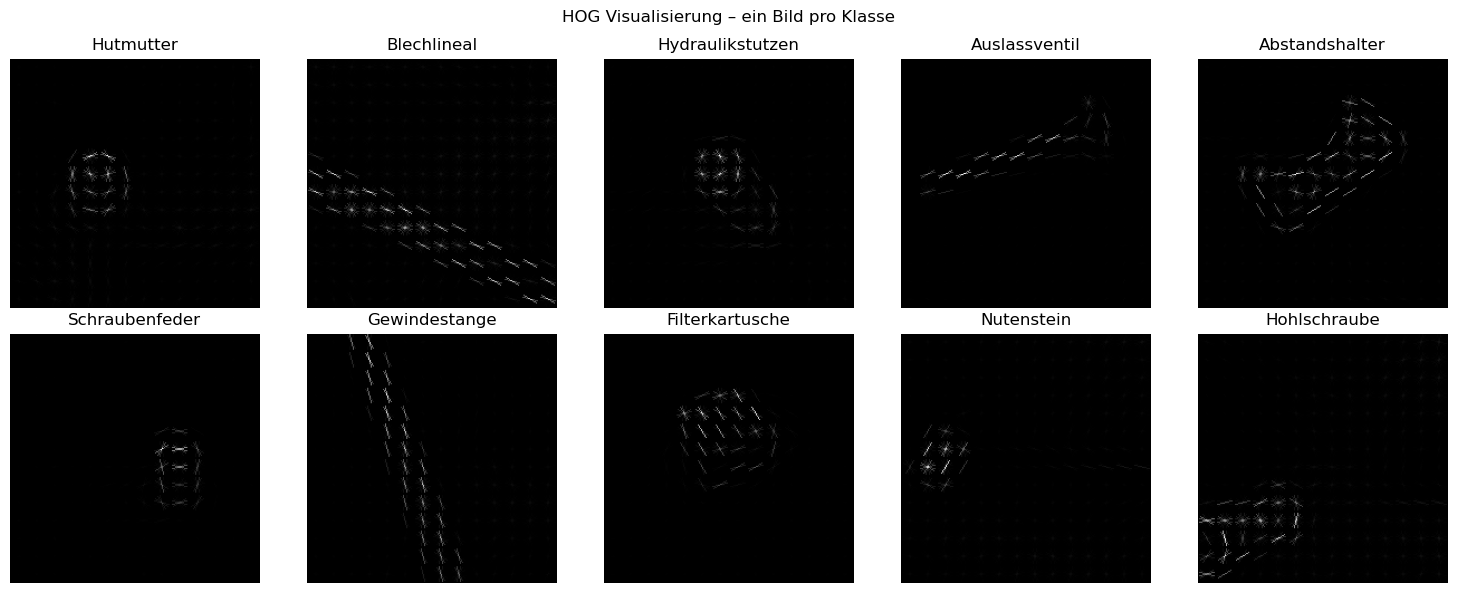

In [53]:
# 可视化用的 HOG 参数（手动添加 visualize=True）
hog_params_vis = hog_params.copy()
hog_params_vis['visualize'] = True

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
shown_classes = set()
idx = 0

for img, label in zip(X_train_img, y_train):
    if label not in shown_classes:
        _, hog_image = hog(img, **hog_params_vis)
        hog_image = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        ax = axes.flat[idx]
        ax.imshow(hog_image, cmap='gray')
        ax.set_title(label)
        ax.axis("off")
        shown_classes.add(label)
        idx += 1
    if idx >= 10:
        break

plt.suptitle("HOG Visualisierung – ein Bild pro Klasse")
plt.tight_layout()
plt.show()


---
Schritt 4 – PCA
- Führt eine PCA auf den Trainingsdaten aus und projiziert die Daten dann in den neuen Merkmalsraum. Das
gibt euch Aufschluss darüber, wie schwierig euer Klassifikationsproblem ist beziehungsweise, wie gut eure
Features geeignet sind, um die Klassen zu unterscheiden.
- Ihr könnt sowohl die OpenCV- als auch die scikit-learn-Bibliothek dafür nutzen.


Die PCA-Projektion der HOG-Merkmale zeigt, dass sich einige Klassen gut voneinander trennen lassen,
während andere (z. B. [Klasse X und Y]) sich im Merkmalsraum überlappen.
Dies gibt Aufschluss darüber, wie trennscharf die extrahierten Features sind und wie schwierig das Klassifikationsproblem ist.

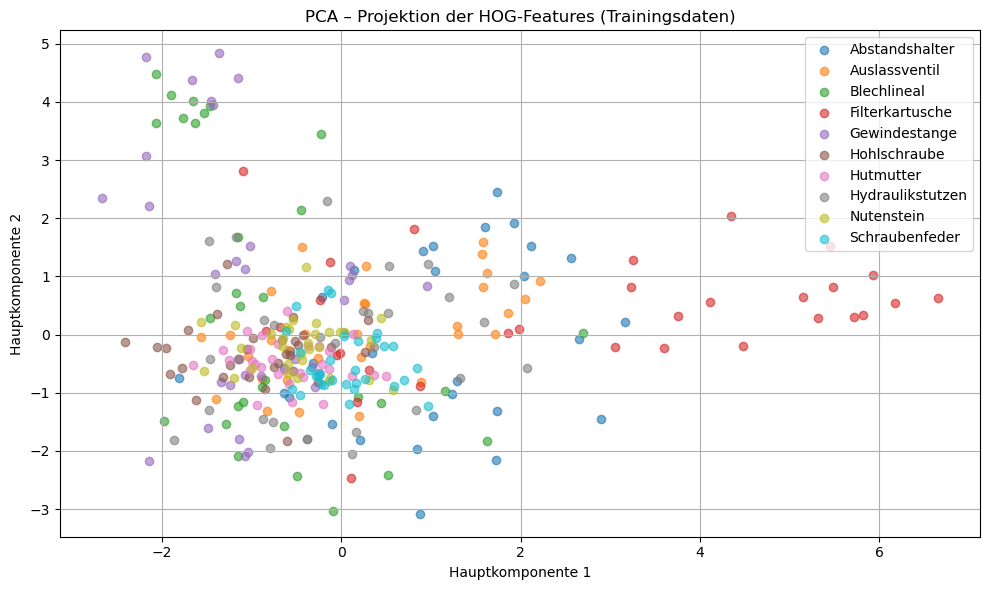

In [54]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 先将高维 HOG 特征降到 2D
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_hog)

# 可视化
plt.figure(figsize=(10, 6))

# 不同颜色表示不同类别
for label in np.unique(y_train_enc):
    idx = y_train_enc == label
    plt.scatter(X_train_pca[idx, 0], X_train_pca[idx, 1], label=label_encoder.inverse_transform([label])[0], alpha=0.6)

plt.title("PCA – Projektion der HOG-Features (Trainingsdaten)")
plt.xlabel("Hauptkomponente 1")
plt.ylabel("Hauptkomponente 2")
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


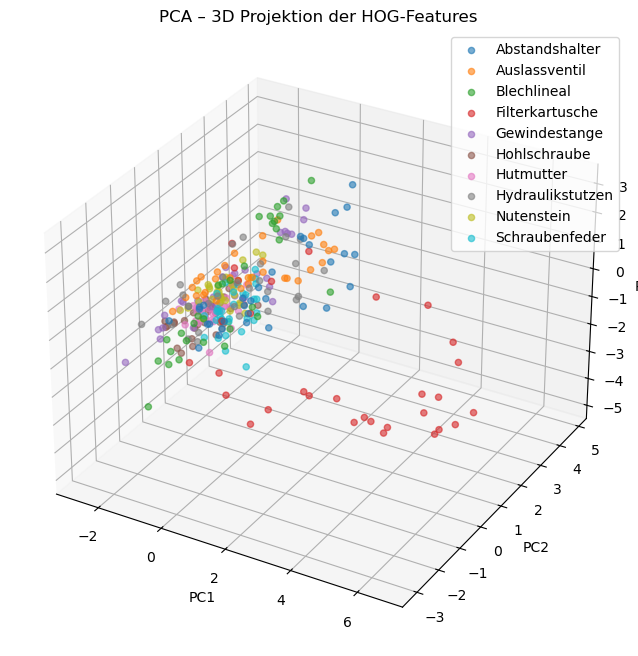

In [55]:
from mpl_toolkits.mplot3d import Axes3D

pca_3d = PCA(n_components=3)
X_train_pca3 = pca_3d.fit_transform(X_train_hog)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for label in np.unique(y_train_enc):
    idx = y_train_enc == label
    ax.scatter(X_train_pca3[idx, 0], X_train_pca3[idx, 1], X_train_pca3[idx, 2],
               label=label_encoder.inverse_transform([label])[0], alpha=0.6)

ax.set_title("PCA – 3D Projektion der HOG-Features")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend(loc='best')
plt.show()


---
Schritt 5 – Klassifikation
- Nutzt einen Klassifikator eurer Wahl aus der in der Übung 3 vorgestellten Klassifikatoren (entweder einen
oder mehrere), um die Klassifikation durchzuführen.
- Betrachtet dabei sowohl die durch die PCA reduzierten Merkmalsvektoren als auch die im Schritt 2
generierten Merkmalsvektoren.

Use the extracted HOG features (X_train_hog, X_val_hog, X_test_hog) or after reduce the dimension with pca and try:
- Naive Bayes
- SVM
- MLP

In [ ]:
# use pca to reduce the dimension
pca = PCA(n_components=150)
X_train_pca = pca.fit_transform(X_t453rain_hog)
X_val_pca = pca.transform(X_val_hog)
X_test_pca = pca.transform(X_test_hog)


In [57]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

nb_clf = GaussianNB()
nb_clf.fit(X_train_pca, y_train_enc)
y_pred_nb = nb_clf.predict(X_val_pca)

print("Naive Bayes Ergebnisse:")
print("Accuracy:", accuracy_score(y_val_enc, y_pred_nb))
print("F1-Score:\n", classification_report(y_val_enc, y_pred_nb, target_names=label_encoder.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_val_enc, y_pred_nb))


Naive Bayes Ergebnisse:
Accuracy: 0.375
F1-Score:
                   precision    recall  f1-score   support

  Abstandshalter       0.67      0.18      0.29        11
   Auslassventil       0.45      0.50      0.48        10
     Blechlineal       0.30      0.27      0.29        11
 Filterkartusche       1.00      0.30      0.46        10
   Gewindestange       0.83      0.50      0.62        10
    Hohlschraube       0.75      0.30      0.43        10
       Hutmutter       0.25      0.27      0.26        11
Hydraulikstutzen       0.30      0.30      0.30        10
      Nutenstein       0.24      1.00      0.38        10
  Schraubenfeder       0.67      0.18      0.29        11

        accuracy                           0.38       104
       macro avg       0.55      0.38      0.38       104
    weighted avg       0.54      0.38      0.38       104

Confusion Matrix:
 [[ 2  3  1  0  0  0  0  5  0  0]
 [ 0  5  0  0  0  1  1  0  3  0]
 [ 0  1  3  0  0  0  1  0  6  0]
 [ 1  1  2  3  1

In [58]:
# SVM
from sklearn.svm import SVC

svm_clf = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
svm_clf.fit(X_train_pca, y_train_enc)
y_pred_svm = svm_clf.predict(X_val_pca)

print("SVM Ergebnisse:")
print("Accuracy:", accuracy_score(y_val_enc, y_pred_svm))
print("F1-Score:\n", classification_report(y_val_enc, y_pred_svm, target_names=label_encoder.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_val_enc, y_pred_svm))


SVM Ergebnisse:
Accuracy: 0.5576923076923077
F1-Score:
                   precision    recall  f1-score   support

  Abstandshalter       0.40      0.36      0.38        11
   Auslassventil       0.89      0.80      0.84        10
     Blechlineal       0.67      0.18      0.29        11
 Filterkartusche       1.00      0.10      0.18        10
   Gewindestange       0.88      0.70      0.78        10
    Hohlschraube       0.46      0.60      0.52        10
       Hutmutter       0.53      0.73      0.62        11
Hydraulikstutzen       0.56      0.90      0.69        10
      Nutenstein       0.48      1.00      0.65        10
  Schraubenfeder       0.38      0.27      0.32        11

        accuracy                           0.56       104
       macro avg       0.62      0.56      0.53       104
    weighted avg       0.62      0.56      0.52       104

Confusion Matrix:
 [[ 4  0  0  0  0  0  0  5  0  2]
 [ 0  8  0  0  0  0  0  0  2  0]
 [ 0  1  2  0  0  4  2  0  2  0]
 [ 6  0  0 

In [59]:
# MLP
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp_clf.fit(X_train_pca, y_train_enc)
y_pred_mlp = mlp_clf.predict(X_val_pca)

print("MLP Ergebnisse:")
print("Accuracy:", accuracy_score(y_val_enc, y_pred_mlp))
print("F1-Score:\n", classification_report(y_val_enc, y_pred_mlp, target_names=label_encoder.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_val_enc, y_pred_mlp))


MLP Ergebnisse:
Accuracy: 0.6346153846153846
F1-Score:
                   precision    recall  f1-score   support

  Abstandshalter       0.58      0.64      0.61        11
   Auslassventil       0.90      0.90      0.90        10
     Blechlineal       0.67      0.18      0.29        11
 Filterkartusche       0.60      0.30      0.40        10
   Gewindestange       0.57      0.80      0.67        10
    Hohlschraube       0.67      0.80      0.73        10
       Hutmutter       0.50      0.45      0.48        11
Hydraulikstutzen       0.69      0.90      0.78        10
      Nutenstein       0.60      0.90      0.72        10
  Schraubenfeder       0.60      0.55      0.57        11

        accuracy                           0.63       104
       macro avg       0.64      0.64      0.61       104
    weighted avg       0.64      0.63      0.61       104

Confusion Matrix:
 [[7 0 0 1 0 0 0 3 0 0]
 [1 9 0 0 0 0 0 0 0 0]
 [0 1 2 0 4 2 1 0 1 0]
 [3 0 0 3 2 0 0 1 0 1]
 [1 0 0 0 8 0 0 0 

---
Schritt 6 – Evaluation
- Zur Beurteilung der Klassifikationsleistung des Klassifikators könnt ihr die CCR auf den Validierungsdaten
berechnen und euch die Konfusionsmatrix anschauen. Dafür könnt ihr beispielsweise die accuracy_score-
Funktion, die confusion_matrix-Funktion und die f1_score-Funktion der scikit-learn-Bibliothek nutzen.
Experimentiert mit den Hyperparametern und vergleicht die Ergebnisse für verschiedene Konfigurationen
eures Klassifikators oder die Ergebnisse mehrerer Klassifikatoren.

**Evaluation abgeschlossen:**

Die Evaluierung (Accuracy, F1-Score, Confusion Matrix) wurde für Naive Bayes, SVM und MLP durchgeführt.
Im Folgenden werden verschiedene Hyperparameter ausprobiert, um die Klassifikationsleistung weiter zu verbessern.


In [60]:
svm_clf = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
svm_clf.fit(X_train_pca, y_train_enc)
y_pred_svm = svm_clf.predict(X_val_pca)

print("SVM (RBF) Ergebnisse:")
print("Accuracy:", accuracy_score(y_val_enc, y_pred_svm))
print("F1-Score:\n", classification_report(y_val_enc, y_pred_svm, target_names=label_encoder.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_val_enc, y_pred_svm))


SVM (RBF) Ergebnisse:
Accuracy: 0.5865384615384616
F1-Score:
                   precision    recall  f1-score   support

  Abstandshalter       0.45      0.45      0.45        11
   Auslassventil       0.89      0.80      0.84        10
     Blechlineal       0.75      0.27      0.40        11
 Filterkartusche       1.00      0.10      0.18        10
   Gewindestange       0.70      0.70      0.70        10
    Hohlschraube       0.58      0.70      0.64        10
       Hutmutter       0.50      0.64      0.56        11
Hydraulikstutzen       0.60      0.90      0.72        10
      Nutenstein       0.53      1.00      0.69        10
  Schraubenfeder       0.44      0.36      0.40        11

        accuracy                           0.59       104
       macro avg       0.64      0.59      0.56       104
    weighted avg       0.64      0.59      0.55       104

Confusion Matrix:
 [[ 5  0  0  0  0  0  0  5  0  1]
 [ 0  8  0  0  0  0  0  0  2  0]
 [ 0  1  3  0  2  2  2  0  1  0]
 [ 6 

In [61]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp_clf.fit(X_train_pca, y_train_enc)
y_pred_mlp = mlp_clf.predict(X_val_pca)

print("MLP Ergebnisse:")
print("Accuracy:", accuracy_score(y_val_enc, y_pred_mlp))
print("F1-Score:\n", classification_report(y_val_enc, y_pred_mlp, target_names=label_encoder.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_val_enc, y_pred_mlp))


MLP Ergebnisse:
Accuracy: 0.6346153846153846
F1-Score:
                   precision    recall  f1-score   support

  Abstandshalter       0.58      0.64      0.61        11
   Auslassventil       0.90      0.90      0.90        10
     Blechlineal       0.67      0.18      0.29        11
 Filterkartusche       0.60      0.30      0.40        10
   Gewindestange       0.57      0.80      0.67        10
    Hohlschraube       0.67      0.80      0.73        10
       Hutmutter       0.50      0.45      0.48        11
Hydraulikstutzen       0.69      0.90      0.78        10
      Nutenstein       0.60      0.90      0.72        10
  Schraubenfeder       0.60      0.55      0.57        11

        accuracy                           0.63       104
       macro avg       0.64      0.64      0.61       104
    weighted avg       0.64      0.63      0.61       104

Confusion Matrix:
 [[7 0 0 1 0 0 0 3 0 0]
 [1 9 0 0 0 0 0 0 0 0]
 [0 1 2 0 4 2 1 0 1 0]
 [3 0 0 3 2 0 0 1 0 1]
 [1 0 0 0 8 0 0 0 

In [ ]:
# 初始化 MLP 分类器（初始参数组合，之后可以尝试其他组合）
mlp = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    alpha=0.001,
    learning_rate_init=0.001,
    max_iter=1000,
    random_state=42
)

# 拟合训练数据
mlp.fit(X_train_hog, y_train_enc)

# 在验证集上预测
y_pred_mlp_hog = mlp.predict(X_val_hog)

# 输出评估结果
print("MLP Ergebnisse (ohne PCA):")
print("Accuracy:", accuracy_score(y_val_enc, y_pred_mlp_hog))
print("F1-Score:\n", classification_report(y_val_enc, y_pred_mlp_hog, target_names=label_encoder.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_val_enc, y_pred_mlp_hog))


📊 MLP Ergebnisse (ohne PCA):
Accuracy: 0.6153846153846154
F1-Score:
                   precision    recall  f1-score   support

  Abstandshalter       0.54      0.64      0.58        11
   Auslassventil       0.89      0.80      0.84        10
     Blechlineal       0.67      0.36      0.47        11
 Filterkartusche       1.00      0.10      0.18        10
   Gewindestange       0.73      0.80      0.76        10
    Hohlschraube       0.60      0.60      0.60        10
       Hutmutter       0.71      0.45      0.56        11
Hydraulikstutzen       0.60      0.90      0.72        10
      Nutenstein       0.56      1.00      0.71        10
  Schraubenfeder       0.43      0.55      0.48        11

        accuracy                           0.62       104
       macro avg       0.67      0.62      0.59       104
    weighted avg       0.67      0.62      0.59       104

Confusion Matrix:
 [[ 7  0  0  0  0  0  0  2  0  2]
 [ 0  8  0  0  0  0  0  0  2  0]
 [ 0  1  4  0  2  2  1  0  1  0